In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import math
import imageio

import ndoperators as ops
import llops as yp
from llops import vec

In [2]:
global_backend = 'arrayfire' # arrayfire or numpy
global_dtype = 'complex32' # complex32 or complex64

ops.setDefaultBackend(global_backend)
ops.setDefaultDatatype(global_dtype)

/Users/zfphil/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


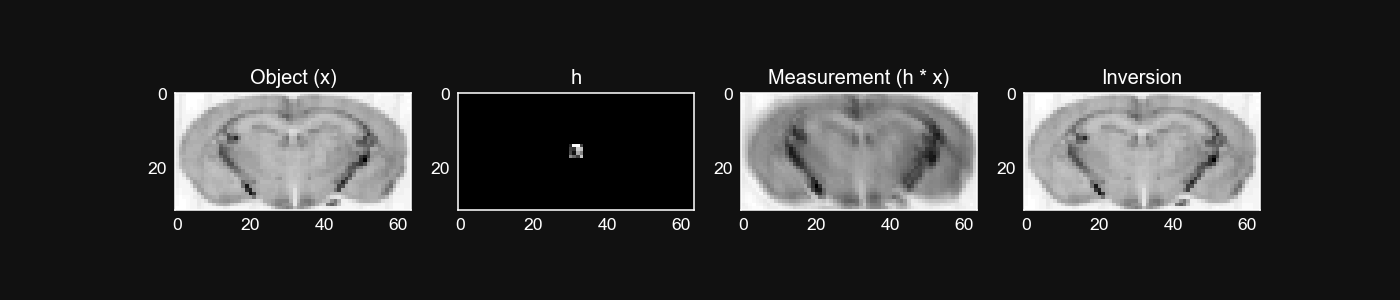

In [4]:
# Image to use when generating object
object_file_name = '../test/brain_to_scan.png'

# Color channel to use when generating object
object_color_channel = 2

# Image size to simulate
image_size = np.array([32, 64])

# Determine machine precision threshold
eps = yp.precision(global_dtype) * np.prod(image_size)

# Load object and crop to size
brain = imageio.imread(object_file_name)
x_0 = np.asfortranarray(sp.misc.imresize(brain, size=image_size)[:, :, object_color_channel].astype(yp.getNativeDatatype(global_dtype, 'numpy')) / 255.)

# Convert object to global default backend
x = yp.changeBackend(x_0)

# Generate convolution kernel h
h_size = np.array([4, 4])
h = yp.zeros(image_size, global_dtype, global_backend)
h[image_size[0] // 2 - h_size[0] // 2:image_size[0] // 2 + h_size[0] // 2,
  image_size[1] // 2 - h_size[1] // 2:image_size[1] // 2 + h_size[1] // 2] = yp.randn((h_size[0], h_size[1]), global_dtype, global_backend)

h /= yp.scalar(yp.sum(yp.abs(h)))

C = ops.Convolution(h, pad_value='mean')
A = C
y = A * x

# Show object and h
plt.figure(figsize=(14,3))
plt.subplot(141)
plt.imshow(yp.abs(yp.changeBackend(x_0, 'numpy')))
plt.title('Object (x)')
plt.subplot(142)
plt.imshow(yp.abs(np.asarray(h)))
plt.title('h')
plt.subplot(143)
plt.imshow((yp.abs(np.asarray(y))))
plt.title('Measurement (h * x)');
plt.subplot(144)
plt.imshow((yp.abs(np.asarray(A.inv * y))))
plt.title('Inversion');

<IPython.core.display.Javascript object>


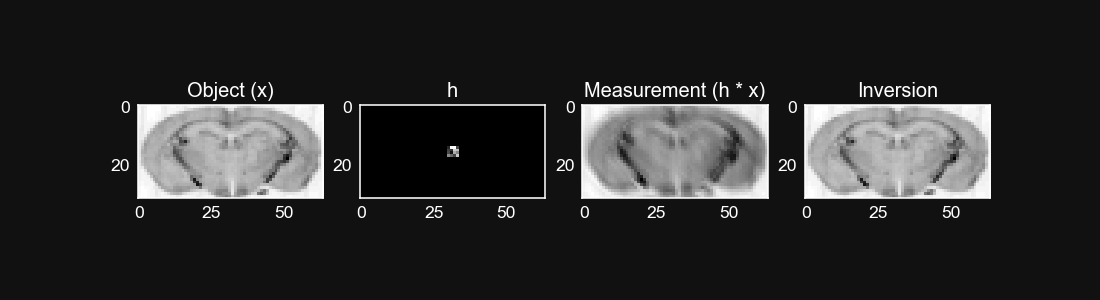

In [6]:
C = ops.Convolution(h, pad_value='mean')
A = C
y = A * x

# Show object and h
plt.figure(figsize=(11,3))
plt.subplot(141)
plt.imshow(yp.abs(yp.changeBackend(x_0, 'numpy')))
plt.title('Object (x)')
plt.subplot(142)
plt.imshow(yp.abs(np.asarray(h)))
plt.title('h')
plt.subplot(143)
plt.imshow((yp.abs(np.asarray(y))))
plt.title('Measurement (h * x)');
plt.subplot(144)
plt.imshow((yp.abs(np.asarray(A.inv * y))))
plt.title('Inversion');

# Function-based convolution

<IPython.core.display.Javascript object>


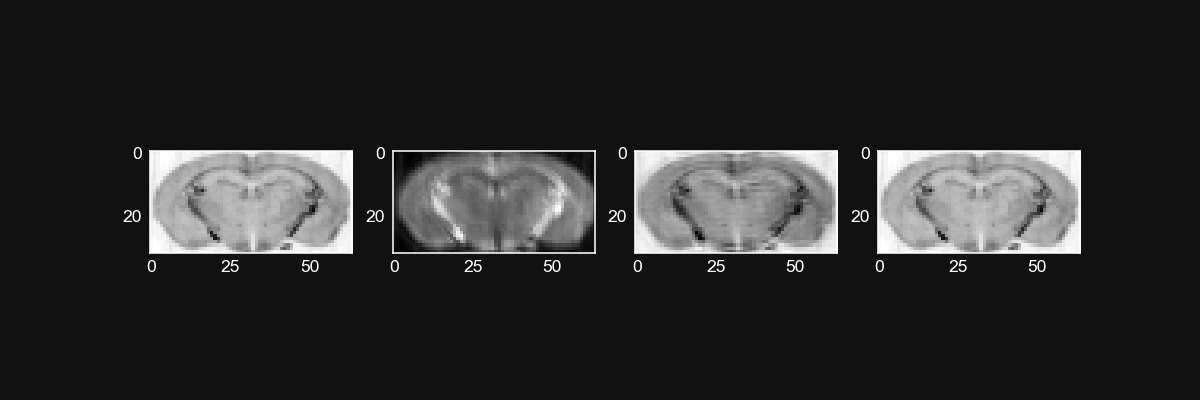

In [7]:
conv_func, conv_adj_func, conv_inv_func, _ = yp.fft.conv_functions(yp.shape(x), h, mode='same', pad_convolution=False, pad_fft=True)

plt.figure()
plt.subplot(141)
plt.imshow(yp.real(x))
plt.subplot(142)
plt.imshow(yp.real(conv_func(x)))
plt.subplot(143)
plt.imshow(yp.real(conv_adj_func(conv_func(x))))
plt.subplot(144)
plt.imshow(yp.real(conv_inv_func(conv_func(x), regularization=1e-8)))

# Function Shortcut-based convolution

<IPython.core.display.Javascript object>


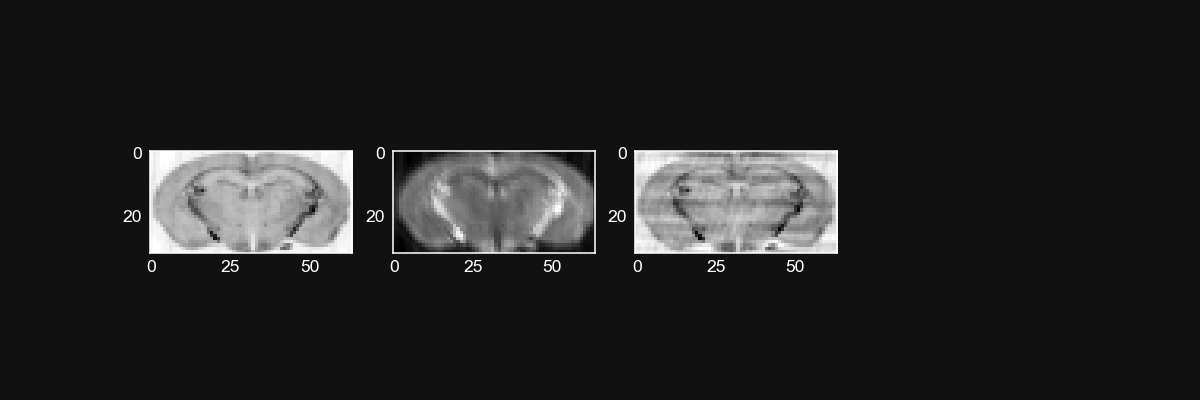

In [8]:
plt.figure()
plt.subplot(141)
plt.imshow(yp.real(x))
plt.subplot(142)
plt.imshow(yp.real(yp.convolve(x, h)))
plt.subplot(143)
plt.imshow(yp.real(yp.deconvolve(yp.convolve(x, h),h)))

## Arrayfire Builtin Convolution

<IPython.core.display.Javascript object>


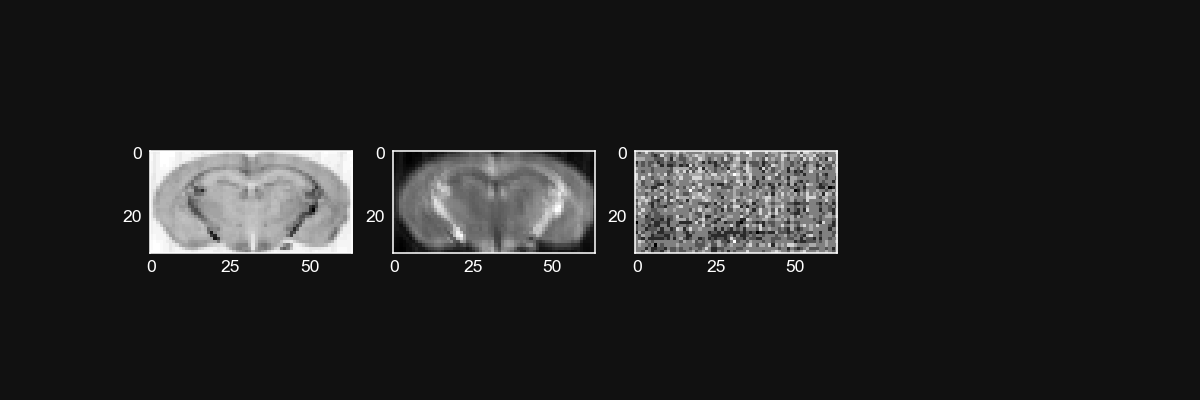

In [33]:
import arrayfire as af

pad_size = [sh + 16 for sh in yp.shape(x)]

xp = yp.pad(x, pad_size, center=True, pad_value='edge')
hp = yp.pad(h, pad_size, center=True, pad_value='edge')
xh = yp.crop(yp.real(af.signal.convolve2(xp, hp)), yp.shape(x), center=True)
plt.figure()
plt.subplot(141)
plt.imshow(yp.real(x))
plt.subplot(142)
plt.imshow(xh)
plt.subplot(143)
plt.imshow(yp.real(xh - yp.convolve(x, h)))